# LORA Finetuning Demonstration

This notebook demonstrates how to finetune a language model using LORA (Low-Rank Adaptation) on the iambic poem dataset.

In [32]:
!uv pip install transformers torch peft datasets matplotlib seaborn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Using Python 3.9.21 environment at: /SCRATCH/manshri/AIDays-Masterclass/.venv
Audited 6 packages in 15ms


In [33]:
!export NCCL_P2P_DISABLE="1"
!export NCCL_IB_DISABLE="1"
%env NCCL_P2P_DISABLE="1"
%env NCCL_IB_DISABLE="1"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


env: NCCL_P2P_DISABLE="1"
env: NCCL_IB_DISABLE="1"


In [34]:
import accelerate
import transformers

transformers.__version__, accelerate.__version__

('4.51.2', '1.6.0')

In [35]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json

## Loading and Preparing Data

Let's load the iambic poem dataset and prepare it for training.

In [36]:
# Load the poem data
with open('../iambic_poem.txt', 'r') as f:
    poems = f.readlines()

# Create dataset
dataset = Dataset.from_dict({"text": poems})

# Load model and tokenizer
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

## Setting up LORA

Configure LORA parameters and prepare the model for training.

In [37]:
# LORA configuration
lora_config = LoraConfig(
    r=8,  # rank
    lora_alpha=16,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "up_proj", "down_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

# Prepare model for LORA training
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, lora_config)

# Print trainable parameters
model.print_trainable_parameters()

trainable params: 4,956,160 || all params: 1,105,004,544 || trainable%: 0.4485


## Training Setup

Configure the training arguments and prepare the dataset.

In [40]:
# Tokenize dataset
# Update the tokenize_function to include labels
def tokenize_function(examples):
    tokenized = tokenizer(
        examples["text"],
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors=None
    )
    # Add labels for language modeling
    tokenized["labels"] = tokenized["input_ids"]
    return tokenized

tokenized_dataset = dataset.map(tokenize_function, batched=True)
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    save_steps=100,
    logging_steps=10,
    learning_rate=2e-4,
    weight_decay=0.01,
    fp16=True,
    eval_strategy="steps",
    eval_steps=100,
    #eval_dataset=tokenized_dataset,
    # Add these new arguments
    gradient_accumulation_steps=4,
    warmup_steps=100,
    save_total_limit=3,
    load_best_model_at_end=True,
    
    # Important: Set this to True for causal language modeling
    remove_unused_columns=False,
    label_names=tokenized_dataset["labels"]
    
)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Visualizing LORA Weights

Let's visualize the LORA weights before and during training.

In [41]:
# Inspect model structure
print("Model structure:")
for name, param in model.named_parameters():
    if "lora" in name.lower():
        print(f"{name}: {param.shape}")

Model structure:
base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight: torch.Size([8, 2048])
base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight: torch.Size([2048, 8])
base_model.model.model.layers.0.self_attn.k_proj.lora_A.default.weight: torch.Size([8, 2048])
base_model.model.model.layers.0.self_attn.k_proj.lora_B.default.weight: torch.Size([256, 8])
base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight: torch.Size([8, 2048])
base_model.model.model.layers.0.self_attn.v_proj.lora_B.default.weight: torch.Size([256, 8])
base_model.model.model.layers.0.self_attn.o_proj.lora_A.default.weight: torch.Size([8, 2048])
base_model.model.model.layers.0.self_attn.o_proj.lora_B.default.weight: torch.Size([2048, 8])
base_model.model.model.layers.0.mlp.up_proj.lora_A.default.weight: torch.Size([8, 2048])
base_model.model.model.layers.0.mlp.up_proj.lora_B.default.weight: torch.Size([5632, 8])
base_model.model.model.layers.0.mlp.down_proj.lora_A.de

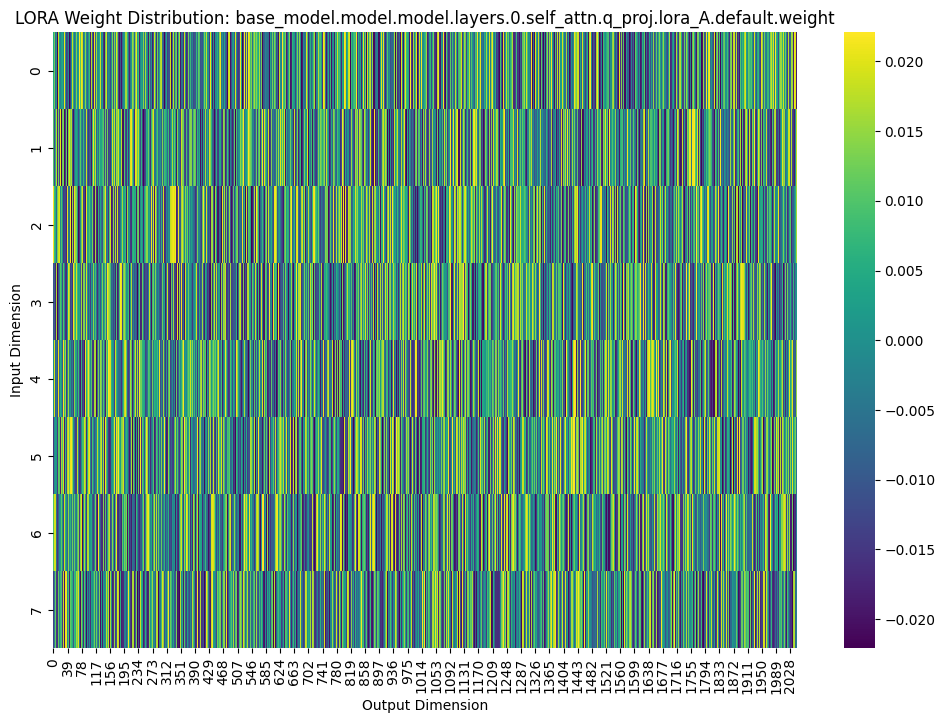

Weight statistics for base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight:
Mean: 0.0001
Std: 0.0128
Min: -0.0221
Max: 0.0221


In [42]:
def plot_lora_weights(model):
    # Find the first LORA layer
    lora_layer = None
    for name, param in model.named_parameters():
        if "lora" in name.lower() and "A" in name:
            lora_layer = name
            break
    
    if lora_layer is None:
        print("No LORA layers found in the model.")
        return
    
    try:
        # Get LORA weights
        lora_weights = model.get_parameter(lora_layer).detach().cpu().numpy()
        
        # Create heatmap
        plt.figure(figsize=(12, 8))
        sns.heatmap(lora_weights, cmap='viridis', center=0)
        plt.title(f'LORA Weight Distribution: {lora_layer}')
        plt.xlabel('Output Dimension')
        plt.ylabel('Input Dimension')
        plt.show()
        
        # Print statistics
        print(f"Weight statistics for {lora_layer}:")
        print(f"Mean: {lora_weights.mean():.4f}")
        print(f"Std: {lora_weights.std():.4f}")
        print(f"Min: {lora_weights.min():.4f}")
        print(f"Max: {lora_weights.max():.4f}")
    except Exception as e:
        print(f"Error plotting weights: {e}")

# Plot initial LORA weights
plot_lora_weights(model)

## Training Loop with Visualization

Train the model and visualize the LORA weights at different stages.

In [43]:
from transformers import DataCollatorForLanguageModeling
# Create trainer
# Create trainer with proper configuration

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    eval_dataset=tokenized_dataset,
    data_collator=DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=False  # Set to False for causal language modeling
    )
)
# Training loop with visualization
for epoch in range(3):
    print(f"\nEpoch {epoch + 1}")
    trainer.train()
    
    # Visualize LORA weights after each epoch
    plot_lora_weights(model)
    
    # Save checkpoint
    trainer.save_model(f"checkpoint-epoch-{epoch+1}")


Epoch 1


ValueError: Unable to create tensor, you should probably activate truncation and/or padding with 'padding=True' 'truncation=True' to have batched tensors with the same length. Perhaps your features (`text` in this case) have excessive nesting (inputs type `list` where type `int` is expected).

## Generating Text

Let's test the finetuned model by generating some iambic poetry.

In [ ]:
def generate_poem(prompt, max_length=100):
    inputs = tokenizer(prompt, return_tensors="pt")
    outputs = model.generate(
        **inputs,
        max_length=max_length,
        num_return_sequences=1,
        temperature=0.7,
        do_sample=True
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Generate some poems
prompt = "The bright light"
generated_poem = generate_poem(prompt)
print("Generated Poem:")
print(generated_poem)